In [70]:
# from google.colab import drive
# drive.mount('/content/drive')

* Import libraries and data

In [259]:
%config IPCompleter.greedy=True
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint
import seaborn as sns
sns.set_style('whitegrid')
import statsmodels.api as sm
from statsmodels.formula.api import ols
import scipy.stats as st
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.linear_model import Lasso, Ridge
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.impute import SimpleImputer
from xgboost.sklearn import XGBRegressor
import xgboost as xgb
%matplotlib inline

train_clean = pd.read_csv('hw4-trainingset-wsa2113.csv')
train = train_clean.copy()
test_clean = pd.read_csv('hw4-testset-wsa2113.csv')
test = test_clean.copy()

print('train shape:',train.shape)
print('test shape:',test.shape)

/Users/barmfield/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (50,53,54,55,56,255,256,257,258,260,268,376) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/barmfield/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (50,255,256,257,258,260,268,280) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


train shape: (20000, 380)
test shape: (24500, 380)


* Create dataframes for preprocessing

In [260]:
train_full = train.drop(['uni','row','job_performance'], axis = 1)
y_train_full = train['job_performance']
X_for_preds = test[train_full.columns]

## EDA  
* Explore target variable

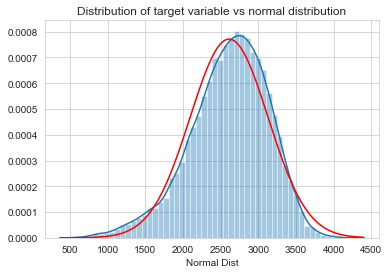

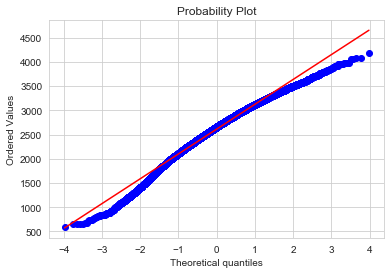

In [262]:
sns.distplot(y_train_full, axlabel='Normal Dist', fit=st.norm, fit_kws={'color':'red'})
plt.title('Distribution of target variable vs normal distribution')
plt.show()
st.probplot(y_train_full, plot=plt)
plt.show()

* Data is close enough to normally distributed.

### Feature Engineering
* I started by finding all columns with null values, then went through them manually to understand the data.
* I noticed that many columns had large numbers of 9995, 9996, etc., which I took to be null values that had been imputed for another system. I needed to change these to np.nan so they could be handled by the imputers.  
* There were also several columns that were extremey high null or did not contain relevant information, which I dropped.  

In [264]:
# go through null columns manually

null_cols = train_full.isnull().sum().sort_values(ascending=False).index.values
null_counts = train_full.isnull().sum().sort_values(ascending=False)
pd.DataFrame(null_counts[null_counts > 0]).to_csv('null_cols.csv')

### Results of data inspection  
* I spent a lot of time trying to determine the best imputation strategy for different columns. In the end, the best strategy was to treat columns with dtype 'object' as categorical features, and all other columns as numerical features. 

In [265]:
nan_vals = [999, 9995, 9995.0, 9996, 9996.0, 9997, 9997.0, 9998, 9998.0,
            9999, 9999.0, 99999, '999', '9995', '9995.0', '9996', '9996.0', '9997', '9997.0', '9998', '9998.0',
            '9999', '9999.0', '99999','C','D','F','Q','I','T','K','   .','H','nan']

cols_to_drop = ['v262','v105','edcat6']

impute_as_mean = ['leavedu','planning','influence','readwork','v202','v231','v272','age_r',
                  'icthome','writhome','yrsqual_t','yrsqual','readhome','readytolearn',
                  'v71','v239','v224']

impute_as_mode = ['v69','nativelang','v85','v50','v225','v101','nfe12njr','v17','v227',
                  'v285','v102','isic2l','v151','paidwork5','v26','v253','v284','v200',
                  'v258','v270','edlevel3','isic2c','v27','ctryrgn','readhome_wle_ca',
                  'writhome_wle_ca','readytolearn_wle_ca','v177','v114','v57','v267','v149',
                  'v260','edcat7','edwork','v218','v171','v14','v111','v186','v132',
                  'v162','computerexperience','v7','v240','v201','fe12','v90','paidwork12',
                  'nopaidworkever','v84','v205','v122','isco1c','v60','aetpop']

impute_as_zero = ['v44','v144','v199','v172','v109','v100','v10','v287','v129','v215',
                  'v163','v268','v252','v37','v169','earnmthselfppp','imyrs','v45',
                  'v78','v22','v241','v194','v283','v154','v113',
                  'v130','v196','v61','v160','v110','v156','v81','v145','v41','v136',
                  'v210','v187','v207','v133','nfehrsjr','nfehrsnjr','v87','earnhrbonusppp',
                  'earnhrbonus','earnmthbonusppp','earnmthbonus','earnhrppp','earnhr',
                  'earnmthppp','earnmth','v184','nfehrs','v104','earnmthall','earnmthallppp',
                  'v63','ictwork','yrsget','v33','learnatwork','writwork','v135','v1',
                  'taskdisc','v52','v235','v242','v97','v94','v206']

impute_as_na = ['v159','v266','v38','v89','v117','v126','v168','v274','v257','v230','v245','v93','v56',
                'v107','v243','v112','v119','v192','v265','v121','v30','v58','v9','v72',
                'v4','v29','v211','leaver1624','v222','v203','v281','v35','v95',
                'v286','v273','v259','v174','v5','v217','v183','v67','v238','v291','v137',
                'v234','v185','v269','v91','v209','v179','v36','vet','v47','v236','v3',
                'v176','v271','v250','v23','v195','ictwork_wle_ca','v146','v106','v73',
                'v40','v277','v289','v96','v62','earnhrbonusdcl','v228','earnhrdcl','v255',
                'v212','cnt_h','v8','earnflag','v221','v48','v115','v19','v251','yearlyincpr',
                'monthlyincpr','v214','learnatwork_wle_ca','v261','ctryqual','v70','v82',
                'v46','v53','cnt_brth','v142','v140','v276','v246','v244','v158','v188',
                'v181','v263','v198','taskdisc_wle_ca','v77','v99','v247','v229','v248',
                'v216','v18','v134','v2','v51','v124','v282','v13','v42','v34','v166',
                'v164','v204','v197','v193','v123','v275','v131','v141','v292','v139',
                'v108','v189','v190','v25','influence_wle_ca','writwork_wle_ca','v173',
                'readwork_wle_ca','v165','planning_wle_ca','v155','v180','v24','v233',
                'v278','v103','v178','v152','v31','birthrgn','icthome_wle_ca','v208',
                'v288','v175','v43','v15','v280','v237','iscoskil4','v256','v153',
                'edcat8','reg_tl2','v28','fnfaet12jr','fnfaet12njr','faet12njr','faet12jr',
                'faet12','fnfaet12','imyrcat','fnfe12jr','nfe12jr','v59','nfe12','v92',
                'nativespeaker','v88','v74','v157','v65','v191','neet','lng_ci','v170',
                'v76','v127','v147','v150','v6','v83','v220',
                'v39','v118','v254','v290','v16','v12','v55','v68','v64','v32','v125',
                'v79','v232','v98', 'v226', 'v161', 'v264', 'v213', 'v20', 'v11', 'v138', 
                'imyrs_c', 'v182','v75','v223','earnmthalldcl','lng_home']

* Replace null values represented by something other than np.nan, and drop meaningless columns
* update data type of certain columns

In [266]:
# for training
train_full = train_full.replace(nan_vals, None).drop(cols_to_drop, axis=1).copy()

train_full['v71'] = train_full['v71'].astype('float')
train_full['isic2l'] = train_full['isic2l'].astype('float')
train_full['isco1c'] = train_full['isco1c'].astype('str')

# for testing
X_for_preds = X_for_preds.replace(nan_vals, None).drop(cols_to_drop, axis=1).copy()

X_for_preds['v71'] = X_for_preds['v71'].astype('float')
X_for_preds['isic2l'] = X_for_preds['isic2l'].astype('float')
X_for_preds['isco1c'] = X_for_preds['isco1c'].astype('str')

* Separate features into numerical and categorical

In [267]:
categorical_obj_cols = train_full.dtypes == object
cat_cols = list(categorical_obj_cols[categorical_obj_cols==True].index.values)
num_cols = list(categorical_obj_cols[categorical_obj_cols==False].index.values)

for col in cat_cols:
    train_full[col] = train_full[col].astype('str')
    X_for_preds[col] = X_for_preds[col].astype('str')
    
for col in num_cols:
    train_full[col] = train_full[col].astype('float')
    X_for_preds[col] = X_for_preds[col].astype('float')

### Feature Engineering Steps

* Numerical Features
    * I imputed missing values for missing numerical columns by using the median, which produced better results than imputing with the mean, which is sensitive to extreme outliers.
    * I added missing value indicator variables for numerical features.
    * In order to capture non-linear relationships between the features and target, I added second degree polynomial interaction features.  
  
  
  
* Categorical Features
    * I imputed missing values for categorical columns with the word 'missing' as many categorical columns were extremely high null, and I didn't want to impute the most frequent entry unless there was a decent chance that that example *could* have held that value.
    * I added missing value indicator variables for categorical features.
    * To give proper weighting to all the different categories in each categorical feature, I also performed one hot encoding.

In [291]:
num_transform = Pipeline(
    [
        ('num_imputer', SimpleImputer(strategy='median', add_indicator=True)),
        ('num_scaler', StandardScaler()),
        ('poly', PolynomialFeatures())
    ]
)

cat_transform = Pipeline(
    [
        ('nan_imputer', SimpleImputer(strategy='constant', fill_value='missing', add_indicator=True)),
        ('onehot', OneHotEncoder(handle_unknown='ignore')),
        ('cat_scaler', StandardScaler(with_mean=False))
    ]
)

preprocessor = ColumnTransformer(
    [
        ('num', num_transform, ~categorical_obj_cols),
        ('cat', cat_transform, categorical_obj_cols),
    ]
)

train_data = preprocessor.fit_transform(train_full).astype('float')
test_data = preprocessor.transform(X_for_preds).astype('float')

# Ensemble Methods  
* I want to use multiple estimators to ensure my model doesn't over fit. I selected XGBoost, Ridge Rigression, and Lasso Regression, because of their ability to handle a large number of features while avoiding overfitting.

## XGBoost
* XGBoost has many advantages, but one drawback is that it has so many tunable features. I took some time to find the optimal parameters, going through them two at a time so I could keep track of progress.
* Tuned parameters:
    * max_depth
    * min_child_weight
    * subsample
    * colsample
    * eta  
    
XGBoost parameter descriptions: https://xgboost.readthedocs.io/en/latest/parameter.html

* Create xgb Dmatrices
* Split data for training

In [292]:
from sklearn.model_selection import train_test_split
import xgboost as xgb

X_train, X_test, y_train, y_test = train_test_split(train_data, y_train_full, random_state=0)

d_train = xgb.DMatrix(data=X_train, label=y_train)
d_test = xgb.DMatrix(data=X_test, label=y_test)
d_full = xgb.DMatrix(data=train_data, label=y_train_full)

/Users/barmfield/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/barmfield/anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


* Grid search max depth and min_child_weight

In [15]:
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse'
}

max_depth = [5, 8, 10, 12]
min_child_weight = [5, 7, 9]
grid = [(d, c) for d in max_depth for c in min_child_weight]

best_test_rmse = 100000000
best_params = (None,None)
for md, mcw in grid:
    print('max_depth:',md)
    print('min_child_weight:',mcw)
    print()
    
    params['max_depth'] = md
    params['min_child_weight'] = mcw
    
    cv_results = xgb.cv(
        params=params,
        dtrain=d_train,
        num_boost_round=20,
        seed=0,
        nfold=3,
        metrics='rmse',
        early_stopping_rounds=10
    )
    
    rmse = cv_results['test-rmse-mean'].min()
    boost_rounds = cv_results['test-rmse-mean'].argmin()
    
    print('Results:')
    print('rmse:',rmse)
    print('boost rounds:',boost_rounds)
    
    if rmse < best_test_rmse:
        best_test_rmse = rmse
        best_params = (md, mcw)

The mse was lowest at max_depth = 8 and min_child_weight = 7

* Grid search subsample and colsample

In [ ]:
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse'
}

sub_sample = [0.8, 0.9, 1]
col_sample = [0.8, 0.9, 1]
grid = [(ss, cs) for ss in sub_sample for cs in col_sample]

best_test_rmse = 100000000
best_params = (None,None)
for ss, cs in grid:
    print('sub_sample:',ss)
    print('col_sample:',cs)
    print()
    
    params['subsample'] = ss
    params['colsample'] = cs
    
    cv_results = xgb.cv(
        params=params,
        dtrain=d_train,
        num_boost_round=20,
        seed=0,
        nfold=3,
        metrics='rmse',
        early_stopping_rounds=10
    )
    
    rmse = cv_results['test-rmse-mean'].min()
    boost_rounds = cv_results['test-rmse-mean'].argmin()
    
    print('Results:')
    print('rmse:',rmse)
    print('boost rounds:',boost_rounds)
    
    if rmse < best_test_rmse:
        best_test_rmse = rmse
        best_params = (ss, cs)

The mse was lowest when subsample = 1 and colsample = 0.8

* Grid search eta

In [ ]:
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'n_estimators': 250
}

sub_sample = [0.8, 0.9, 1]
col_sample = [0.8, 0.9, 1]
eta_param = [0.35, 0.4, 0.45, 0.5]


best_test_rmse = 100000000
best_param = None
for e in eta_param:
    print('eta:', e)
    print()
    
    params['eta'] = e
    
    cv_results = xgb.cv(
        params=params,
        dtrain=d_train,
        num_boost_round=20,
        seed=0,
        nfold=3,
        metrics='rmse',
        early_stopping_rounds=10
    )
    
    rmse = cv_results['test-rmse-mean'].min()
    boost_rounds = cv_results['test-rmse-mean'].argmin()
    
    print('Results:')
    print('rmse:',rmse)
    print('boost rounds:',boost_rounds)
    
    if rmse < best_test_rmse:
        best_test_rmse = rmse
        best_params = e

The mse was lowest when eta = 0.3

* Train model on best parameters

In [296]:
params = {
    'alpha': 0.5,
    'lambda': 0.001,
    'n_estimators': 350,
    'max_depth': 8,
    'min_child_weight': 7,
    'subsample': 1,
    'colsample': 0.8,
    'eta': 0.3,
    'eval_metric': 'rmse',
    'objective': 'reg:squarederror',
    'n_jobs': 8
}

r = xgb.XGBRegressor(**params)
r.fit(X_train,y_train)
rp = r.predict(X_test)

In [ ]:
mean_squared_error(y_test, rp)

## Ridge Regression  
* This Ridge model was trained using cloud resources so I could also work in my local notebook. I used grid search and cross validation through many different choices to find the best alpha parameter, and the results are pasted below.

In [ ]:
from sklearn.linear_model import RidgeCV

ridge_alphas = [28500,28750, 29000, 29250, 29500]
ridge = RidgeCV(alphas=ridge_alphas, store_cv_values=True)
ridge.fit(X_train, y_train)

In [297]:
best_ridge_alpha = 29500

In [298]:
from sklearn.linear_model import Ridge

best_ridge = Ridge(alpha=best_ridge_alpha)
best_ridge.fit(X_train, y_train)
ridge_preds = best_ridge.predict(X_test)

In [299]:
mean_squared_error(y_test, ridge_preds)

145551.48038959102

## Lasso Regression

* The best parameters for this Lasso model were also grid searched remotely.

In [ ]:
from sklearn.linear_model import LassoCV

lasso_alphas = [2.3, 2.4, 2.5, 2.6, 2.7]
lasso = LassoCV(alphas=lasso_alphas, 
                cv=3, 
                max_iter=3000,
                random_state=0)

lasso.fit(X_train, y_train)

In [300]:
best_lasso_alpha = 2.5

In [301]:
from sklearn.linear_model import Lasso

best_lasso_alpha = 2.5
best_lasso = Lasso(alpha=best_lasso_alpha)
best_lasso.fit(train_data, y_train_full)
lasso_preds = best_lasso.predict(X_test)

In [302]:
mean_squared_error(y_test, lasso_preds)

94078.44039403835

In [280]:
mean_squared_error(y_test, lasso_preds)

94078.44039403835

## Find best weights for each model
* The rows in iters are all combinations of weights which sum to 1

In [ ]:
from sklearn.metrics import mean_squared_error

w_xgb = [i/10 for i in range(11)]
w_lasso = [i/10 for i in range(11)]
w_ridge = [i/10 for i in range(11)]

iters = np.array([[w1,w2,w3] for w1 in w_xgb for w2 in w_lasso for w3 in w_ridge])
iters = iters[np.sum(iters, axis=1) == 1]

best_mse = np.inf
best_weights = np.array([0,0,0])

for weights in iters:
    preds = weights[0]*rp + weights[1]*ridge_preds + weights[2]*lasso_preds
    mse = mean_squared_error(preds, y_test)
    
    if mse < best_mse: 
        best_mse = mse
        best_weights = weights
        
print('Best xgb weight:',best_weights[0])
print('Best ridge weight:',best_weights[1])
print('Best lasso weight:',best_weights[2])
print('Best MSE:',best_mse)

* The optimal weight is to just use lasso.

* Retrain lasso on all training data

In [303]:
final_lasso = Lasso(alpha=best_lasso_alpha)
final_lasso.fit(train_data, y_train_full)

final_preds = final_lasso.predict(test_data)

In [304]:
test_clean.job_performance = final_preds

In [305]:
test_clean.shape

(24500, 380)

In [306]:
test_clean.job_performance[:5]

0    2362.781923
1    2344.401196
2    3041.325486
3    2221.474201
4    2426.415046
Name: job_performance, dtype: float64

In [307]:
test_clean.to_csv('hw4-testset-wsa2113-submission.csv')

In [95]:
r = xgb.XGBRegressor(**params)
r.fit(X_train,y_train)
rp = r.predict(X_test)
mean_squared_error(y_test, rp)

98185.21859622147

In [96]:
r = xgb.XGBRFRegressor(**params)
r.fit(X_train,y_train)
rp = r.predict(X_test)
mean_squared_error(y_test, rp)

/Users/barmfield/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


145168.40762410944

In [733]:
# start 11:01
rs.cv_results_['mean_test_score']

array([-0.40520564, -0.40214941, -0.4044895 , -0.39921245, -0.44710897,
       -0.38225046, -0.39295984, -0.40214941, -0.39065052, -0.38504598])

In [734]:
rs.best_params_

{'n_estimators': 450,
 'min_child_weight': 7,
 'max_depth': 8,
 'lambda': 0.001,
 'eta': 0.1,
 'colsample_by_tree': 0.5,
 'alpha': 0.46415888336127775}

* cv with best params

In [460]:
from sklearn.metrics import mean_squared_error

In [768]:
best_params

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'importance_type': 'gain',
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 100,
 'n_jobs': 1,
 'nthread': None,
 'objective': 'reg:squarederror',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': None,
 'silent': None,
 'subsample': 1,
 'verbosity': 2}

In [737]:
Xy_train_xgb = xgb.DMatrix(data=train_data, label=y_train)

best_xgb = xgb.XGBRegressor(objective ='reg:squarederror', booster='gbtree',verbosity=2)

params = {
    'n_estimators': 100,
    'min_child_weight': 7,
    'max_depth': 8,
    'lambda': 0.001,
    'eta': 0.1, 
    'colsample_by_tree': 0.5,
    'alpha': 10
}

cv_results = best_xgb.cv(dtrain=Xy_train_xgb, 
                    params=params, 
                    nfold=3,
                    verbose_eval=1,
                    num_boost_round=50,
                    early_stopping_rounds=10,
                    metrics='rmse', 
                    as_pandas=True, 
                    seed=123)

[0]	train-rmse:1.05601+0.00367115	test-rmse:1.05983+0.00818064
[1]	train-rmse:1.0021+0.0031126	test-rmse:1.00992+0.00779551
[2]	train-rmse:0.954913+0.00242656	test-rmse:0.966969+0.00745312
[3]	train-rmse:0.913326+0.00195859	test-rmse:0.93034+0.00709549
[4]	train-rmse:0.87675+0.00165816	test-rmse:0.898648+0.00650573
[5]	train-rmse:0.844611+0.00123436	test-rmse:0.871159+0.00686839
[6]	train-rmse:0.816272+0.000977887	test-rmse:0.847365+0.00641282
[7]	train-rmse:0.790155+0.000905692	test-rmse:0.826053+0.0058726
[8]	train-rmse:0.767177+0.00113996	test-rmse:0.807606+0.00579646
[9]	train-rmse:0.746889+0.000890693	test-rmse:0.79175+0.00524545
[10]	train-rmse:0.728641+0.000545593	test-rmse:0.778112+0.00500932
[11]	train-rmse:0.712099+0.000509858	test-rmse:0.765401+0.00477401
[12]	train-rmse:0.697234+0.000932657	test-rmse:0.754579+0.00434044
[13]	train-rmse:0.683484+0.000724808	test-rmse:0.744982+0.00418028
[14]	train-rmse:0.671478+0.000740955	test-rmse:0.736231+0.0035156
[15]	train-rmse:0.66015

In [738]:
mse = cv_results["test-rmse-mean"].tail(1).values[0]**2
print('Average MSE = {:.2f}'.format(mse))

Average MSE = 0.43


In [766]:
best_params = best_xgb.get_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'importance_type': 'gain',
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 100,
 'n_jobs': 1,
 'nthread': None,
 'objective': 'reg:squarederror',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': None,
 'silent': None,
 'subsample': 1,
 'verbosity': 2}

* retrain and evaluate on test data

In [ ]:
Xy_final_xgb = xgb.DMatrix(data=train_data, label=y_train)

final_xgb = xgb.XGBRegressor(objective ='reg:squarederror', booster='gbtree',verbosity=2)

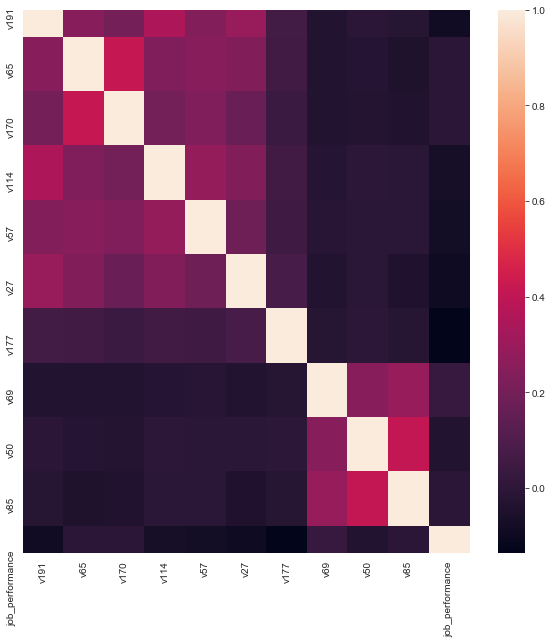

In [80]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline

s = """v191,v65,v170,v114,v57,v27,v177,v69,v50,v85""".split(',')
s.append('job_performance')

pipe = Pipeline([
    ('imp', SimpleImputer(strategy='most_frequent')),
    ('enc', OrdinalEncoder())
])

d = pd.DataFrame(data=pipe.fit_transform(train_full[s]), columns=s)
corr = d.corr()

plt.figure(figsize=(10,10))
sns.heatmap(corr)


In [84]:
d.iloc[:,:-1].sum(axis=1).corr(d.job_performance)

-0.106889359963189

In [512]:
x_train_sample = pd.concat((train_full, y_train), axis=1).sample(5000)
y_train_sample = x_train_sample.job_performance
x_train_sample = x_train_sample.drop('job_performance', axis=1)